Contributions from:

* DSEverything - Mean Mix - Math, Geo, Harmonic (LB 0.493) 
https://www.kaggle.com/dongxu027/mean-mix-math-geo-harmonic-lb-0-493

* JdPaletto - Surprised Yet? - Part2 - (LB: 0.503)
https://www.kaggle.com/jdpaletto/surprised-yet-part2-lb-0-503

* hklee - weighted mean comparisons, LB 0.497, 1ST
https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st

In [1]:
import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
import xgboost
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
%matplotlib inline

/Users/mariuszrokita/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mariuszrokita/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/mariuszrokita/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module wi

## Load data

In [2]:
data = {
    'tra': pd.read_csv('../data/raw/air_visit_data.csv',
                parse_dates=['visit_date']),
    'as':  pd.read_csv('../data/raw/air_store_info.csv'),
    'hs':  pd.read_csv('../data/raw/hpg_store_info.csv'),
    'ar':  pd.read_csv('../data/raw/air_reserve.csv',
                parse_dates=['visit_datetime', 'reserve_datetime']),
    'hr':  pd.read_csv('../data/raw/hpg_reserve.csv',
                parse_dates=['visit_datetime', 'reserve_datetime']),
    'id':  pd.read_csv('../data/raw/store_id_relation.csv'),
    'tes': pd.read_csv('../data/raw/sample_submission.csv'),
    'hol': pd.read_csv('../data/raw/date_info.csv')
                .rename(columns={'calendar_date':'visit_date'})
}

## Feature engineering

In [3]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

for df in ['ar','hr']:
    # Get rid of time portion as is not that important in our case
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date    
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = \
        data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
        
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False) \
        [['reserve_datetime_diff', 'reserve_visitors']].sum() \
            .rename(columns={'visit_datetime':'visit_date', 
                             'reserve_datetime_diff': 'rs1', 
                             'reserve_visitors':'rv1'})            
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False) \
        [['reserve_datetime_diff', 'reserve_visitors']].mean() \
            .rename(columns={'visit_datetime':'visit_date', 
                             'reserve_datetime_diff': 'rs2', 
                             'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

In [4]:
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

In [5]:
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 
                                  'dow': [i]*len(unique_stores)}) 
                    for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [6]:
#sure it can be compressed...
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

## Prepare Train and Test datasets

In [7]:
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

In [8]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

## Model Fitting

### Model 1 - Gradient Boosting Regressor

In [9]:
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, 
                                            random_state=3, 
                                            n_estimators=5, # best result: 200 
                                            subsample=0.8, 
                                            max_depth =10,
                                            verbose=1)
print(model1)

model1.fit(train[col], np.log1p(train['visitors'].values))
preds1 = model1.predict(train[col])
print('RMSLE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds1))
preds1 = model1.predict(test[col])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=5, presort='auto', random_state=3, subsample=0.8,
             verbose=1, warm_start=False)
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5066           0.1424           32.32s
         2           0.4145           0.0915           24.80s
         3           0.3535           0.0590           17.02s
         4           0.3128           0.0387            8.28s
         5           0.2876           0.0246            0.00s
RMSLE GradientBoostingRegressor:  0.536513354862


In [10]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    #print("Train sizes:", train_sizes)
    #print("Train scores:", train_scores)
    #print("Test scores:", print(test_scores))
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5125           0.1513            1.37s
         2           0.4033           0.0935            0.99s
         3           0.3318           0.0643            0.66s
         4           0.2789           0.0390            0.34s
         5           0.2499           0.0235            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5036           0.1447            5.94s
         2           0.4065           0.0916            4.28s
         3           0.3452           0.0585            2.82s
         4           0.2982           0.0390            1.40s
         5           0.2721           0.0238            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5042           0.1470            9.63s
         2           0.4072           0.0935            7.29s
         3           0.3447           0.0593            4.82s
     

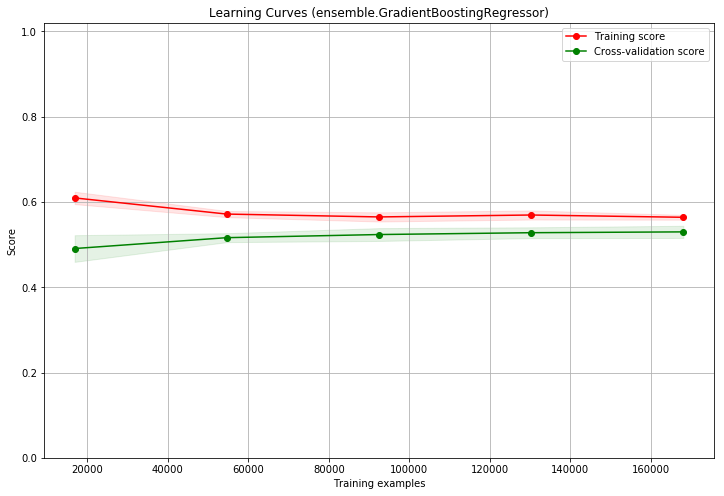

In [16]:
plt = plot_learning_curve(model1, "Learning Curves (ensemble.GradientBoostingRegressor)", 
                          train[col], np.log1p(train['visitors'].values), ylim=(0.0, 1.02), cv=None, n_jobs=1)
plt.show()

### Model 2 - KNeighborsRegressor

In [12]:
#model2 = neighbors.KNeighborsRegressor(n_jobs=-1, 
#                                       n_neighbors=4)
#print(model2)
#
#model2.fit(train[col], np.log1p(train['visitors'].values))
#preds2 = model2.predict(train[col])
#print('RMSLE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds2))
#preds2 = model2.predict(test[col])

### Model 3 - XGBRegressor

In [13]:
#model3 = XGBRegressor(max_depth =12, 
#                      learning_rate=0.2, 
#                      n_estimators=20, # originally 280, 
#                      subsample=0.8, 
#                      colsample_bytree=0.8, 
#                      seed=3)
#print(model3)
#
#%timeit model3.fit(train[col], np.log1p(train['visitors'].values))
#preds3 = model3.predict(train[col])
#print('RMSLE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))
#preds3 = model3.predict(test[col])

In [14]:
#test['visitors'] = 0.3*preds1+0.3*preds2+0.4*preds3
test['visitors'] = preds1
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()

# TODO: delete unneeded 
#del train; del data;

In [15]:
# from hklee
# https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st/code
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob('../data/raw/*.csv')}

for k, v in dfs.items(): locals()[k] = v

wkend_holidays = date_info.apply(
    (lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  

visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

wmean = lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) # cumbersome, should be better ways.

sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['calendar_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission.drop('visitors', axis=1, inplace=True)
sample_submission = sample_submission.merge(date_info, on='calendar_date', how='left')
sample_submission = sample_submission.merge(visitors, on=[
    'air_store_id', 'day_of_week', 'holiday_flg'], how='left')

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), 
    how='left')['visitors_y'].values

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), 
    on='air_store_id', how='left')['visitors_y'].values

sample_submission['visitors'] = sample_submission.visitors.map(pd.np.expm1)
sub2 = sample_submission[['id', 'visitors']].copy()
sub_merge = pd.merge(sub1, sub2, on='id', how='inner')

sub_merge['visitors'] = 0.7*sub_merge['visitors_x'] + 0.3*sub_merge['visitors_y']* 1.1
sub_merge[['id', 'visitors']].to_csv('../output/submission.csv', index=False)